## Background 

Zillow is an online real estate database company. Its prediction, Zestimate home valuation has shaken up the U.S. real estate industry since first released 11 years ago.

In this project, Zillow Prize, is a competition with a one million dollar grand prize, to help push the accuracy of the Zestimate even further. 

Briefly speaking, we are required to predict home price based on conditions of the industry, of the house and of the market. 

## Preparation

In [1]:
# package intallation 
import numpy as np
import pandas as pd

In [2]:
# import dataset 
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

In [3]:
# familiarize dataset 
train_df.head(4)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000


here we could see there are about 80 columns, which means we have 80 features we should consider when predicting sales price.

In [4]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Before start, we have to make sure our target column 'SalePrice' is normalized. 
Here we could use histogram to plot the distribution.  

We could find the dataset price is not normally distributed, it's right skewed, which is not good for our model. 

In order to make our regressors more accurate, we have to normalize the label, which is a very important step. Many outcomes are not good because some of them miss this part.

There are several ways to solve this problem. The most common and useful way is to use log function. 
Here we use log(x+1), but remember we should normalize it back when we finish our model in the last step. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110710128>]], dtype=object)

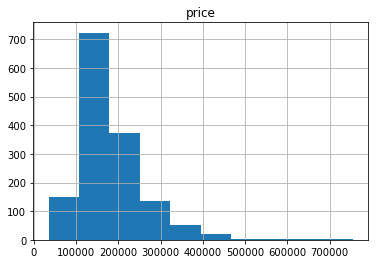

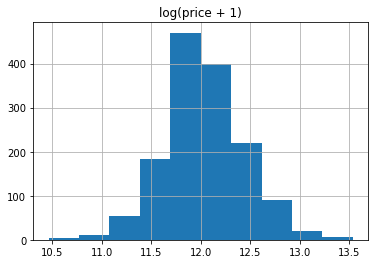

In [5]:
%matplotlib inline
prices = pd.DataFrame({"price":train_df["SalePrice"]})
prices.hist()
# normalize price 
prices_norm = pd.DataFrame({"log(price + 1)":np.log1p(train_df["SalePrice"])})
prices_norm.hist()

Here we combine two datasets, train dataset and test dataset. This is for we can do feature engineering together and save time.

In [6]:
# combine train_df & test_df to clean data together
y_train = np.log1p(train_df.pop('SalePrice'))
all_df = pd.concat((train_df, test_df), axis=0)
all_df.shape

(2919, 79)

In [34]:
y_train.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

## Feature Engineering 

The next step is feature engineering, again, it's one of the most important part in machine learning. Everyone can use advanced machinea learning models, however, everyone will use different feature engineering methods, thus causing the difference of the ourcomes.

Firstly, we could take a look at the types of our columns.

In [8]:
all_df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


We could find there are some categorical columns which cannot be used in regression model if we do not deal with it. 
Here, we can use one-hot method dummies code to turn all of them to numerical columns. 

In [9]:
# change MSSubClass from type int64 to type string 
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [10]:
# change categorical columns with one-hot by get_dummies function
# for example
pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [11]:
# apply the method to all categorical columns 
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


So, here, after one-hot method, we could find original 80 columns turn to about 300 columns.

Then we need to deal with null values. The dataset is not clean, we could find a lot of missing values here. Especially the column 'LogFrontage'. After cheking the definition of these columns, we find the most logical method to deal with these missing values is not to drop them but replace them with mean values. 

In [12]:
# check null values 
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

so here we replace null values with mean. 

In [13]:
# replace null values with mean (logically)
mean_cols = all_dummy_df.mean()
all_dummy_df = all_dummy_df.fillna(mean_cols)
#then check if there is null value 
all_dummy_df.isnull().sum().sum()

0

The last step of feature engineering is to standardize numerical columns. 
since regression model is very sensitive, standardization could help solve the problem. 
We use the basic standarization method to do it. Original values - mean, then by standard deviation. 

In [14]:
# standardize numerical columns 
#since regression model is sensitive, standardization could help solve the problem

# to find numerical columns 
numeric_cols = all_df.columns[all_df.dtypes != 'object']
# standardization
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

After feature engineering, we finally could move on to model buidling. 

## Build Model 

Before model building, remember to split it back to testing & training dataset. 

In [15]:
# split it back to testing & training dataset 
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

Here I used two regression models, one if ridge regression 
the other one is random forest. 

### Model 1 Ridge Regression

In [16]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [17]:
# change from df to numpy array, which fits Sklearn better 
X_train = dummy_train_df.values
X_test = dummy_test_df.values

In [18]:
# cross validation to test the model 
# to find the better alpha (hyperparameter)
alphas = np.logspace(-3, 2, 50)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

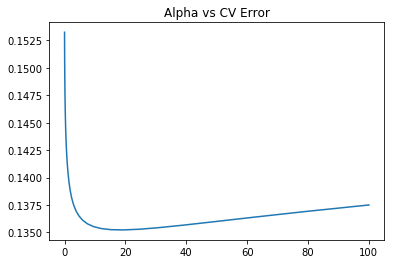

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error");

# we could find when alpha = 10~20, score could be the smallest around 0.135

## Model 2 Random Forest

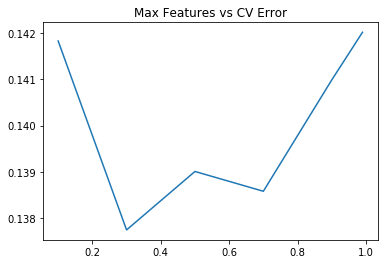

In [20]:
from sklearn.ensemble import RandomForestRegressor
max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

# to find the best hyperparameter    
plt.plot(max_features, test_scores)
plt.title("Max Features vs CV Error")
# we could find the best socre could be 0.137 (worse than ridge regression result)

Later, I used ensemble method, bagging and bossting, to optimize the outcome. 
Before start, I'd like to share some of my basic understanding of ensemble method, bagging and boosting. 
Bagging and Boosting are not machine learning models. I prefer to call them framewords. 
They are both ensemble techniques, where a set of weak learners are combined to create a strong learner that obtains better performance than a single one.

The main causes of error in learning are due to noise, bias and variance. Ensemble helps to minimize these factors. These methods are designed to improve the stability and the accuracy of Machine Learning algorithms. Combinations of multiple classifiers decrease variance, especially in the case of unstable classifiers, and may produce a more reliable classification than a single classifier.

## 1. Combine Models using Average Method

Strictly speaking, this is not ensemble method. I just average the outcomes from the above two models 

In [21]:
# select the best alpha 15 and best feature .3
ridge = Ridge(alpha=15)
rf = RandomForestRegressor(n_estimators=500, max_features=.3)

ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
# change log(1+x) back 
y_ridge = np.expm1(ridge.predict(X_test))
y_rf = np.expm1(rf.predict(X_test))

In [23]:
# Average them 
y_final = (y_ridge + y_rf) / 2

In [24]:
# Final Output 
submission_df = pd.DataFrame(data= {'Id' : test_df.index, 'SalePrice': y_final})
submission_df.head(10)

,Id,SalePrice
0,1461,118990.249544
1,1462,150909.112400
2,1463,173820.037137
3,1464,188890.041003
4,1465,194646.575477
5,1466,176125.660373
6,1467,177790.836321
7,1468,168896.830705
8,1469,184999.597063
9,1470,123090.895085


## 2.  Ridge Model & Bagging method

In [25]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

In [26]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values

In [27]:
# the best alpha 15
from sklearn.linear_model import Ridge
ridge = Ridge(15)

In [28]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

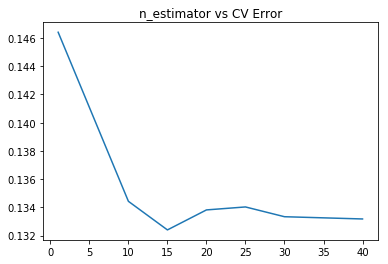

In [35]:
# select the number of regressors in Bagging
params = [1, 10, 15, 20, 25, 30, 40]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
    

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error")
# we could find when the number of regressors is 15, we could get a smaller result 0.133 with bagging method

## 3.  Ridge Model &  Boosting method (Adaboost)

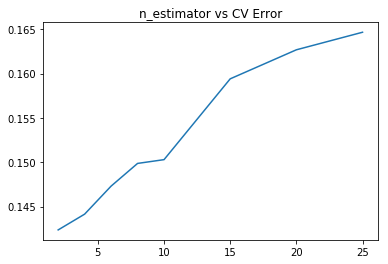

In [38]:
from sklearn.ensemble import AdaBoostRegressor
params = [2,4,6,8,10,15,20,25]
test_scores = []
for param in params:
    clf = AdaBoostRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
    
    
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error")
# Here we could find, when ridge model is combined with adaboosting method, the whole model is unstable.
# As the number of regressors is increasing, the error is larger.  

### 4. XGBoost Method

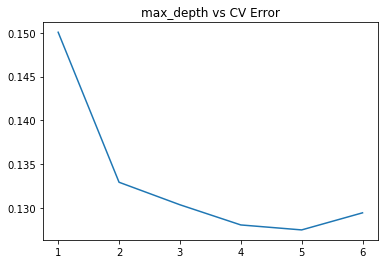

In [32]:
from xgboost import XGBRegressor
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
    

    
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error");

# When regressor is 5, we can get CV error 0.127

We could see the excellent performance of XGBoost. Even I found most kaggle winners are using XGBoost, so some of them call XGBoost Kaggle-must-have. 
Why use XGBoost?
the key features of this library rely on model performance and execution speed. A well-structured clear benchmark shows how XGBoost outperforms several other well-known implementations of gradient tree boosting.
Here we could see from the picture below. 

<img width="701" alt="p1" src="https://user-images.githubusercontent.com/32689388/37236151-d12ca554-23b9-11e8-8fca-a5339c1a4f9a.png">


This comparison in the picture helps us grasp the power of the tool and see how well balanced its benefits are,it does not seem to sacrifice speed over accuracy or vice versa. so, it's clear why more Kagglers are using it every day, we could say it is a semi-perfect equilibrium of both performance and time-efficiency.
So,if you are interested, I recommend all of us could learn some about it. 